<a href="https://colab.research.google.com/github/vmartinezarias/Curso_Ecologia_Paisaje_y-Ecoacustica/blob/main/5%20-%20Conectividad_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Workflow para análisis de conectividad funcional empleando el paquete Omniscape del lenguaje de programación Julia. Información de Omniscape puede encontrarse en: https://docs.circuitscape.org/Omniscape.jl/latest/


Omniscape requere:
1. Un ráster de resistencia
2. Un archivo de configuración .ini

En este workflow se generará la resistencia a partir de las coberturas DW ya descargadas, y el archivo de configuración. Se podrán hacer análisis tanto dirigidos, como omnidireccionales.


# Instalar entorno de JULIA

In [ ]:
# Eliminar cualquier versión anterior de Julia
!rm -rf /opt/julia-1.*
!rm /usr/local/bin/julia

# Descargar la última versión de Julia (1.11.1) e instalarla
!wget https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.1-linux-x86_64.tar.gz
!tar -xvzf julia-1.11.1-linux-x86_64.tar.gz
!mv julia-1.11.1 /opt/
!ln -s /opt/julia-1.11.1/bin/julia /usr/local/bin/julia

# Verificar la instalación de Julia
!julia --version

# instalar rasterio, Numpy y folijum
!pip install rasterio numpy
!pip install folium


# Instalar Omniscape

In [ ]:
!julia -e 'using Pkg; Pkg.add("Circuitscape")'
!julia -e 'using Pkg; Pkg.add("Omniscape")'

# Cargar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



# Construcción de matriz de resistencia a partir de las coberturas DW

Aquí se deben calificar los valores de resistencia para el análisis de conectividad.

Para ello, se debe editar esta parte:

resistance_values = {
    0: 10,   # Agua
    1: 1,    # Árboles
    2: 5,    # Pastos
    3: 3,    # Vegetación acuática
    4: 6,    # Cultivos
    5: 3,    # Arbustales
    6: 10,   # Construcción
    7: 9,    # Desnudo
    8: 10    # Hielo y nieve
}


el formato es el siguiente:

valor_original: valorresistencia, # Nombre_cobertura



In [ ]:
# instalar rasterio y Numpy
#!pip install rasterio numpy

import numpy as np
import rasterio
from rasterio.windows import Window
from scipy.ndimage import uniform_filter
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo ráster original
raster_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Coberturas_DW.tif'
# Ruta para guardar el nuevo archivo de resistencia
output_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resistencia.tif'

# Definir la matriz de resistencia, asignando un valor de resistencia a cada clase
# Asegúrate de ajustar estos valores según la especie. No usar valores menores a 1.
resistance_values = {
    0: 10,   # Agua
    1: 1,    # Árboles
    2: 5,    # Pastos
    3: 3,    # Vegetación acuática
    4: 6,    # Cultivos
    5: 3,    # Arbustales
    6: 10,   # Construcción
    7: 9,    # Desnudo
    8: 10    # Hielo y nieve
}

# Parámetro para decidir si aplicar el análisis de vecindad o no
apply_smoothing = True  # Cambia a False si no deseas aplicar el filtro de vecindad

# Leer el archivo ráster
with rasterio.open(raster_path) as src:
    # Leer los datos de la primera banda
    raster_data = src.read(1)

    # Crear una matriz de resistencia aplicando los valores del diccionario
    resistance_data = np.copy(raster_data)
    for key, value in resistance_values.items():
        resistance_data[raster_data == key] = value

    # Aplicar el filtro de vecindad de 3x3 (promedio) si apply_smoothing es True
    if apply_smoothing:
        resistance_data = uniform_filter(resistance_data, size=15)

    # Crear un perfil para el archivo de salida
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1, compress='lzw')

    # Guardar el nuevo archivo ráster con la matriz de resistencia
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(resistance_data.astype(rasterio.float32), 1)

print(f"Archivo de resistencia guardado en: {output_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo de resistencia guardado en: /content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resistencia.tif


# Visualizar coberturas y la resistencia generada

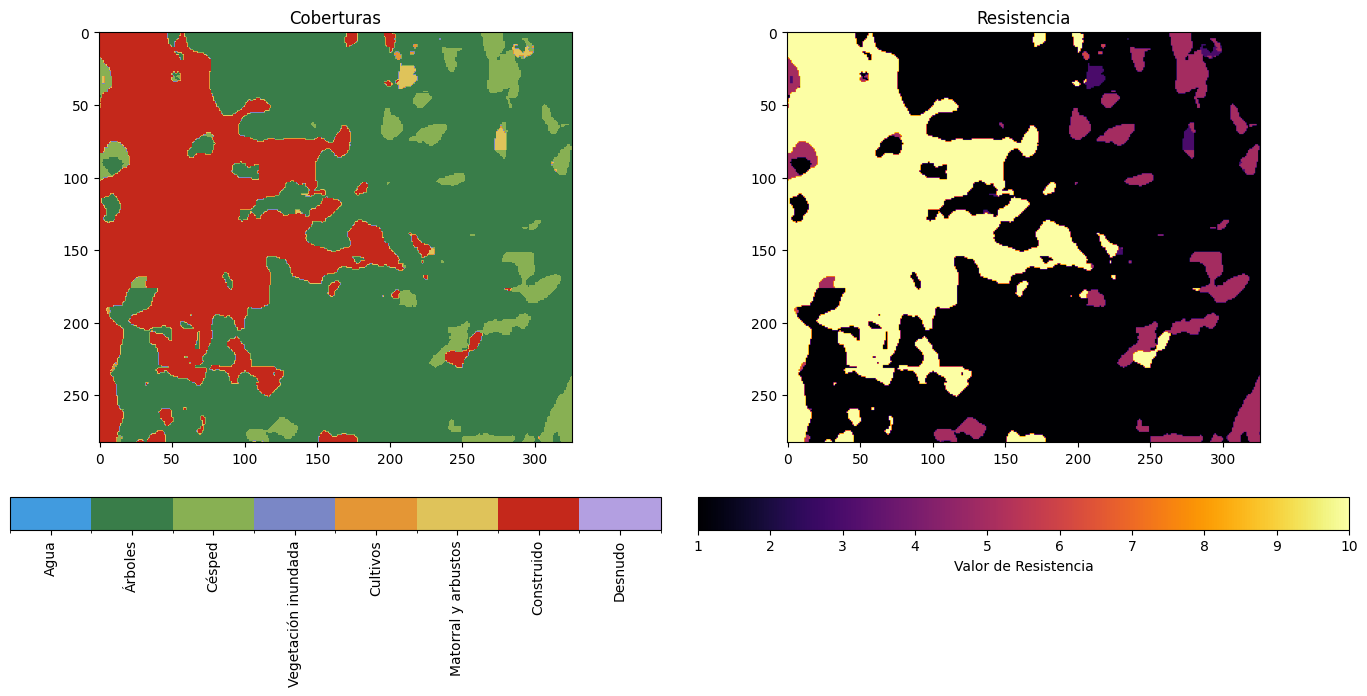

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Definir los colores y etiquetas en español para el ráster de coberturas según la tabla proporcionada
coverage_colors = ['#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1']
coverage_labels = ["Agua", "Árboles", "Césped", "Vegetación inundada", "Cultivos", "Matorral y arbustos", "Construido", "Desnudo", "Nieve y hielo"]
coverage_values = np.arange(9)  # Valores del 0 al 8 correspondientes a cada clase
coverage_cmap = ListedColormap(coverage_colors)
norm = BoundaryNorm(coverage_values - 0.5, len(coverage_colors))

# Rutas de los archivos ráster
coverage_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Coberturas_DW.tif'
resistance_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resistencia.tif'

# Cargar los datos de los archivos ráster
with rasterio.open(coverage_path) as coverage_src, rasterio.open(resistance_path) as resistance_src:
    coverage_data = coverage_src.read(1)
    resistance_data = resistance_src.read(1)

# Configurar la visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Mostrar el ráster de coberturas con los colores y etiquetas personalizadas
c1 = ax1.imshow(coverage_data, cmap=coverage_cmap, norm=norm)
ax1.set_title("Coberturas")

# Añadir la leyenda personalizada para coberturas con etiquetas giradas 90°
cbar1 = fig.colorbar(c1, ax=ax1, orientation="horizontal", pad=0.1, ticks=coverage_values)
cbar1.set_ticklabels(coverage_labels)  # Usar las etiquetas en español
for label in cbar1.ax.get_xticklabels():
    label.set_rotation(90)  # Girar etiquetas para mejor alineación

# Mostrar el ráster de resistencia con la escala "inferno"
c2 = ax2.imshow(resistance_data, cmap='inferno')
ax2.set_title("Resistencia")

# Añadir una barra de color para la resistencia
cbar2 = fig.colorbar(c2, ax=ax2, orientation="horizontal", label="Valor de Resistencia", pad=0.1)

plt.tight_layout()
plt.show()


# Generar archivo.ini para el análisis de conectividad en omniscape.

Los resultados que deben ser modificados en este caso son

radius: Corresponde al radio de búsqueda del algoritmo. Puede interpretarse como distancia lineal de movimiento.

block_size: (siempre en múltiplos de 3). Corresponde a la "resolución" del análisis.

Parallel_batch_size: Para versiones pagadas de COLAB, se pueden usar más procesadores.

source_from_resistance: si es true, entonces no hace multidireccional (desde cada pixel), sino que lo que hace es que la corriente sale desde valores establecidos en "r_cutoff". Si es False el análisis es multidireccional.

r_cutoff: valor máximo de resistencia para que se considere como una "salida".




In [ ]:
import os

# Definir la ruta para el archivo .ini
ini_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/entrada_omniscape.ini'

# Contenido del archivo .ini
ini_content = """
[Required]

resistance_file = /content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resistencia.tif
radius = 35
block_size = 3
project_name =  /content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resultados/Conectividad


[General options]

source_from_resistance = true
r_cutoff = 2
calc_normalized_current = true
calc_flow_potential = true
solver = "cholmod"



[Processing options]

parallelize = true

parallel_batch_size = 50



[Output options]

write_as_tif = true
"""

# Crear el archivo .ini con el contenido
with open(ini_path, 'w') as file:
    file.write(ini_content.strip())

print(f"Archivo .ini creado en: {ini_path}")


Archivo .ini creado en: /content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/entrada_omniscape.ini


# Correr análisis en omniscape

In [ ]:
!julia -e 'using Omniscape; run_omniscape("/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/entrada_omniscape.ini")'

# Graficar Resultados

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Rutas de los archivos .tif de resultados
base_path = "/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resultados/Conectividad"
files = ["normalized_cum_currmap.tif", "flow_potential.tif", "cum_currmap.tif"]

# Nombres para los títulos de las gráficas
titles = ["Mapa de Corriente Acumulada Normalizada", "Potencial de Flujo", "Mapa de Corriente Acumulada"]

# Configurar la visualización
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Iterar sobre los archivos y graficarlos
for i, file_name in enumerate(files):
    file_path = f"{base_path}/{file_name}"
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Leer la primera banda
        cax = axes[i].imshow(data, cmap="jet")  # Mostrar con la paleta 'jet'
        axes[i].set_title(titles[i])
        plt.colorbar(cax, ax=axes[i], orientation="horizontal", label="Valor")

plt.tight_layout()
plt.show()
